# Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn import ensemble

# Open CSV

In [2]:
opps = pd.read_csv("data/concat_data.csv")

drop_col = opps.columns[0]

if "unnamed" in drop_col.lower():
    opps = opps.drop(drop_col, 1)



* * *

### Save Features before changes


In [3]:
save_features = {
                    "Opportunity ID" : None,
                    "Account ID" : None, 
                    "Building ID" : None
                }

for save_feature in save_features.keys():
    save_series = opps[save_feature]
    save_features[save_feature] = save_series

## Encode String data to ints

In [4]:
column_names = list(opps.columns)

encode_dict = {}
decode_dict = {}

# Encode string values to int values
for column_name in column_names:
    dtype = opps[column_name].dtype
    if dtype == object:
        
        if column_name == "StageName" or column_name in save_features:
            continue
            
        current_series = opps[column_name]
        current_encode_dict = { key : int(index) for index, key in enumerate(current_series.unique())}
        current_decode_dict = { int(index) : key  for index, key in enumerate(current_series.unique())}

        
        new_series = pd.Series([current_encode_dict[val] for val in current_series])
        opps[column_name] = new_series
        encode_dict[column_name] = current_encode_dict
        decode_dict[column_name] = current_decode_dict

opps.fillna(value=0)

opps.head(3)


,Opportunity ID,Account ID,StageName,IsClosed,IsWon,CreatedDate,Term in Months,Service,Opportunity Type,Product Group,...,X36 NRR List,X36 MRC List,Longitude,Latitude,Industry,Estimated Build Cost,Net Classification,Vertical,Type,Total BRR
0,Opp-000001,Acct-000007,Closed - Lost,True,False,0,12.0,0,0,0,...,1073.717164,1775.345373,-84.391561,33.755431,NaN,11993.5,0,0,0,1334080.00
1,Opp-000002,Acct-000986,5 - Accepted,True,True,0,60.0,0,0,1,...,4610.000000,3163.050000,-84.060881,34.035421,NaN,21243.7,0,1,1,2910.34
2,Opp-000002,Acct-000986,5 - Accepted,True,True,0,60.0,0,0,1,...,4610.000000,3163.050000,-84.063305,34.036374,NaN,17522.2,1,1,1,2910.34


# Feature Engineering

Let's see what we're working with (the opps dataframe!)

In [5]:
opps.columns

Index(['Opportunity ID', 'Account ID', 'StageName', 'IsClosed', 'IsWon',
       'CreatedDate', 'Term in Months', 'Service', 'Opportunity Type',
       'Product Group', 'Building ID', 'Market', 'Street Address', 'City',
       'State', 'Postal Code', 'Network Proximity', 'On Zayo Network Status',
       'Building Type', 'NumberOfEmployees', 'DandB Total Employees',
       'X36 NPV List', 'AnnualRevenue', 'X36 NRR List', 'X36 MRC List',
       'Longitude', 'Latitude', 'Industry', 'Estimated Build Cost',
       'Net Classification', 'Vertical', 'Type', 'Total BRR'],
      dtype='object')

### Dropped Features
- Opportunity ID
- Account ID
- IsClosed
- IsWon
- CreatedDate
- Building ID
- Street Address
- Longitude
- Latitude

In [6]:
drop_features = ["IsClosed", "IsWon", "CreatedDate", "Street Address", "Longitude", "Latitude", "Opportunity ID", "Account ID", "Building ID"]

saved_features_df = opps[drop_features].copy()

opps_dropped = opps.copy(deep=True)
for drop_feature in drop_features:
    opps_dropped = opps_dropped.drop(drop_feature, 1)


#### Confirm Columns are Dropped

In [7]:
drop_success = True
for drop_feature in drop_features:
    if drop_feature in opps_dropped.columns:
        drop_success = False
        break
        
print("Drop {}!".format("Successful" if drop_success else "Unsuccessful"))

Drop Successful!


### Aggregate Features

StageName 

In [8]:
# Define stage_names series
stage_names = opps_dropped["StageName"]

# Define sorting for stage names
stage_name_sorter = {    
                        "Closed - Lost" : 0, 
                        "1 - Working" : -1, 
                        "2 - Best Case" : -1, 
                        "3 - Committed" : 1, 
                        "4 - Closed" : 1, 
                        "5 - Accepted" : 1
                    }

# Loop through stage names and sort
clf_data = []
clf_unlabeled_data = []
clf_unlabeled_data_id_dict = {}

for save_feature in save_features:
    clf_unlabeled_data_id_dict[save_feature] = []

for index, stage_name in enumerate(stage_names):
    classifier = stage_name_sorter[stage_name]
    
    # Save into unlabeled data
    if classifier == -1:
        clf_unlabeled_data.append(list(opps_dropped.loc[index][1:]))
        for save_feature in save_features:
            clf_unlabeled_data_id_dict[save_feature].append(save_features[save_feature][index])
    
    # Save for training data
    else:
        current_data = list(opps_dropped.loc[index][1:])
        current_data.append(classifier)
        clf_data.append(current_data)

### Training Data Dataframe

In [9]:
# Declare column names and remove StageName
column_names = list(opps_dropped.columns)
del column_names[column_names.index("StageName")]

# Add "Y_Label" Column
column_names.append("Y_Label")

# Define the unlabaled data dataframe
clf_data_df = pd.DataFrame(clf_data, columns=column_names)

# Fill NaN values
clf_data_df = clf_data_df.fillna(value=0.0)

clf_data_df.head(3)

,Term in Months,Service,Opportunity Type,Product Group,Market,City,State,Postal Code,Network Proximity,On Zayo Network Status,...,AnnualRevenue,X36 NRR List,X36 MRC List,Industry,Estimated Build Cost,Net Classification,Vertical,Type,Total BRR,Y_Label
0,12.0,0,0,0,0,0,0,30303,66.45,0,...,0.0,1073.717164,1775.345373,0.0,11993.5,0,0,0,1334080.00,0
1,60.0,0,0,1,0,1,0,30024,374.79,0,...,0.0,4610.000000,3163.050000,0.0,21243.7,0,1,1,2910.34,1
2,60.0,0,0,1,0,1,0,30024,250.74,0,...,0.0,4610.000000,3163.050000,0.0,17522.2,1,1,1,2910.34,1


### Unlabeled Data Dataframe

In [10]:
# Declare column names and remove StageName
column_names = list(opps_dropped.columns)
del column_names[column_names.index("StageName")]

# Define the unlabaled data dataframe
clf_unlabeled_data_df = pd.DataFrame(clf_unlabeled_data, columns=column_names)

# Fill NaN values
clf_unlabeled_data_df = clf_unlabeled_data_df.fillna(value=0.0)

clf_unlabeled_data_df.head(3)

,Term in Months,Service,Opportunity Type,Product Group,Market,City,State,Postal Code,Network Proximity,On Zayo Network Status,...,X36 NPV List,AnnualRevenue,X36 NRR List,X36 MRC List,Industry,Estimated Build Cost,Net Classification,Vertical,Type,Total BRR
0,-1.0,0,0,0,0,0,0,30309,185.76,0,...,33413.167626,0.000000e+00,1395.266259,2821.670576,0.0,15572.8,0,3,3,0.0
1,-1.0,0,0,2,0,0,0,30309,185.76,0,...,33413.167626,0.000000e+00,1395.266259,2821.670576,0.0,15572.8,0,3,3,0.0
2,-1.0,0,0,0,0,0,0,30303,66.45,0,...,23266.981628,1.988192e+11,1126.085581,1285.116977,0.0,11993.5,0,2,2,683378.0


# Random Forest

### Setup Classifier

In [11]:
clf_data_df = clf_data_df.fillna(value = 0.0)

clf = ensemble.RandomForestClassifier()

fraction = 9.0/10.0

## Setup Training Data and Fit Classifier

In [12]:
# Sample the clf data
shuffled = clf_data_df.sample(frac=1)

# Setup Features and Prediction columns
features = list(clf_data_df.columns)
del features[features.index("Y_Label")]
features_dict = { val:key for val, key in enumerate(features)}
prediction = "Y_Label"

# Setup the Training data
trainX = shuffled[features][:int(round(fraction*len(shuffled)))].values
trainY = shuffled[prediction][:int(round(fraction*len(shuffled)))].values
trainY = np.reshape(trainY, (len(trainY),))

# Fit the classifier
clf = clf.fit(trainX, trainY)


## Score

In [13]:
testX = shuffled[features][int(round(fraction*len(shuffled))):].values
testY = shuffled[prediction][int(round(fraction*len(shuffled))):].values
print(clf.score(testX, testY))

0.792828685259


## Feature Ranking Plot

Feature ranking:
 1. Term in Months                 0.1887
 2. Total BRR                      0.1153
 3. X36 MRC List                   0.0655
 4. X36 NPV List                   0.0637
 5. X36 NRR List                   0.0612
 6. NumberOfEmployees              0.0544
 7. Vertical                       0.0543
 8. Network Proximity              0.0515
 9. Product Group                  0.0493
10. Estimated Build Cost           0.0468
11. DandB Total Employees          0.0457
12. Postal Code                    0.0370
13. City                           0.0352
14. AnnualRevenue                  0.0346
15. Type                           0.0333
16. Net Classification             0.0144
17. Opportunity Type               0.0121
18. State                          0.0106
19. Market                         0.0100
20. Service                        0.0085
21. On Zayo Network Status         0.0078
22. Industry                       0.0000
23. Building Type                  0.0000


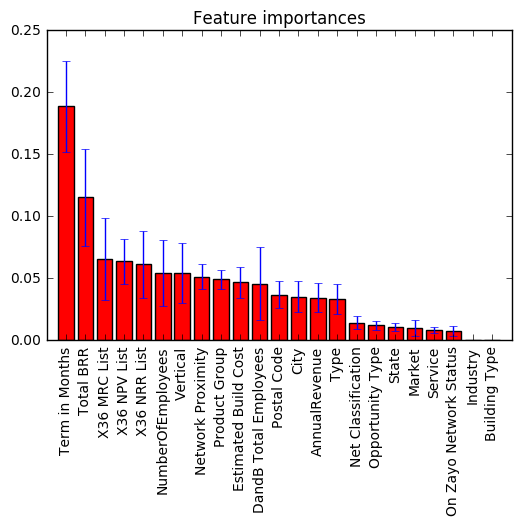

In [14]:
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# Plot the feature importances of the forest
x_labels = [features_dict[val] for val in indices]

for f in range(trainX.shape[1]):
    print("{:2d}. {:30s} {:0.4f}".format(f + 1, x_labels[f], importances[indices[f]]))

    



plt.figure()
plt.title("Feature importances")
plt.bar(range(trainX.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(trainX.shape[1]), x_labels, rotation='vertical')
plt.xlim([-1, trainX.shape[1]])
plt.show()


# Find the Accounts of Interest

In [15]:
clf_unlabeled_data_df.head(2)

,Term in Months,Service,Opportunity Type,Product Group,Market,City,State,Postal Code,Network Proximity,On Zayo Network Status,...,X36 NPV List,AnnualRevenue,X36 NRR List,X36 MRC List,Industry,Estimated Build Cost,Net Classification,Vertical,Type,Total BRR
0,-1.0,0,0,0,0,0,0,30309,185.76,0,...,33413.167626,0.0,1395.266259,2821.670576,0.0,15572.8,0,3,3,0.0
1,-1.0,0,0,2,0,0,0,30309,185.76,0,...,33413.167626,0.0,1395.266259,2821.670576,0.0,15572.8,0,3,3,0.0


In [16]:
predict_y = clf.predict(clf_unlabeled_data_df)

# Prediction frame
predict_y_df = pd.DataFrame(predict_y, columns=["Prediction"])

# test_data_id_df = pd.DataFrame(test_data_id, columns=["Opportunity ID"])
opportunities_id_df = pd.DataFrame(clf_unlabeled_data_id_dict["Opportunity ID"], columns=["Opportunity ID"])
account_id_df = pd.DataFrame(clf_unlabeled_data_id_dict["Account ID"], columns=["Account ID"])


predict_df = pd.concat([account_id_df, opportunities_id_df, clf_unlabeled_data_df, predict_y_df], axis=1)

good_ops = predict_df[predict_df['Prediction'] == 1]
bad_ops = predict_df[predict_df['Prediction'] == 0]

good_ops_ids = good_ops["Opportunity ID"]
good_ops_ids_unique = good_ops_ids.unique()

bad_ops_ids = bad_ops["Opportunity ID"]
bad_ops_ids_unique = bad_ops_ids.unique()

num_good_ops = len(good_ops_ids_unique)
num_bad_ops = len(bad_ops_ids_unique)
print("Number of good opportunities: {}".format(num_good_ops))
print("Number of bad opportunities: {}".format(num_bad_ops))

predict_df.head(5)

Number of good opportunities: 562
Number of bad opportunities: 1223


,Account ID,Opportunity ID,Term in Months,Service,Opportunity Type,Product Group,Market,City,State,Postal Code,...,AnnualRevenue,X36 NRR List,X36 MRC List,Industry,Estimated Build Cost,Net Classification,Vertical,Type,Total BRR,Prediction
0,Acct-000143,Opp-000004,-1.0,0,0,0,0,0,0,30309,...,0.000000e+00,1395.266259,2821.670576,0.0,15572.8,0,3,3,0.0,0
1,Acct-000143,Opp-000005,-1.0,0,0,2,0,0,0,30309,...,0.000000e+00,1395.266259,2821.670576,0.0,15572.8,0,3,3,0.0,0
2,Acct-000011,Opp-000006,-1.0,0,0,0,0,0,0,30303,...,1.988192e+11,1126.085581,1285.116977,0.0,11993.5,0,2,2,683378.0,0
3,Acct-000427,Opp-000011,36.0,0,0,0,2,5,2,75207,...,0.000000e+00,2351.832000,5066.962000,0.0,26388.0,0,5,5,0.0,0
4,Acct-000034,Opp-000012,36.0,0,0,2,2,5,2,75207,...,0.000000e+00,1248.820400,1900.795040,0.0,26388.0,0,6,0,1541759.0,1


## Decode

In [17]:
predict_decode_df = predict_df.copy(deep=True)

column_names = list(predict_decode_df.columns)

# Encode string values to int values
for column_name in column_names:
    if column_name in encode_dict and column_name not in save_features:
        current_series = predict_decode_df[column_name]
        
       
        try:
            new_series = pd.Series([decode_dict[column_name][int(val)] for val in current_series])
            predict_decode_df[column_name] = new_series
        except:
            pass
      

positive_predict = predict_decode_df[predict_decode_df["Prediction"] == 1]

market_counts = positive_predict["Market"].value_counts()
profit_counts = positive_predict["X36 NPV List"].value_counts()


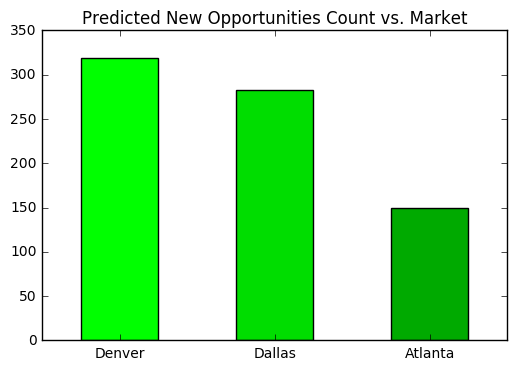

In [18]:
market_counts[:10].plot(kind="bar", rot=0, color=['#00ff00', '#00dd00', '#00aa00'])
plt.title("Predicted New Opportunities Count vs. Market")
plt.show()

# Prospective Profits per market

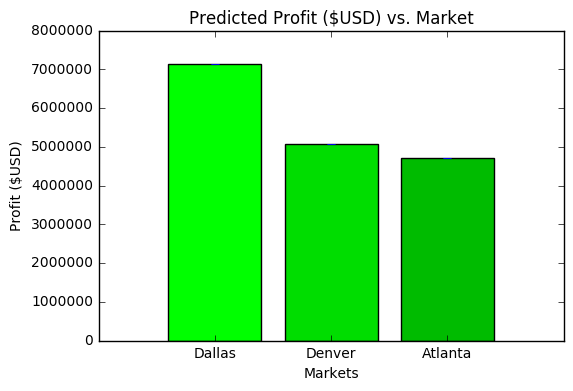

In [19]:
denver_profit_series = positive_predict[positive_predict["Market"] == "Denver"]
atlanta_profit_series = positive_predict[positive_predict["Market"] == "Atlanta"]
dallas_profit_series = positive_predict[positive_predict["Market"] == "Dallas"]

denver_profit = np.sum(denver_profit_series["X36 NPV List"])
atlanta_profit = np.sum(atlanta_profit_series["X36 NPV List"])
dallas_profit = np.sum(dallas_profit_series["X36 NPV List"])

profits = {"Denver" : denver_profit, "Atlanta" : atlanta_profit, "Dallas" : dallas_profit}

profit_values = np.array(list(profits.values()))
profit_keys = np.array(list(profits.keys()))
# plt.bar(te, zw)



indices = np.argsort(profit_values)[::-1]

colors = np.array(["#00ff00", "#00dd00", "#00bb00"])

plt.figure()
plt.title("Predicted Profit ($USD) vs. Market")
plt.xlabel("Markets")
plt.ylabel("Profit ($USD)")
plt.bar([0,1,2], profit_values[indices],
       color=colors, yerr=std[indices], align="center")

plt.xticks([0,1,2], profit_keys[indices], rotation='horizontal')
plt.xlim([-1, 3])
plt.show()

